<a href="https://colab.research.google.com/github/samuel-haddad/diabetes_detection/blob/main/logit_model_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diabetes detection: Logit Model Review**
**Keywords:** GLM, GLM Logistic Regression, Logit

## **GLM: Logistic Regression Theory**

##### **Logit libs & methodology**

**statsmodel** <br>
Para o procedimento clássico, a partir de testes estatísticos, segue-se as  etapas básicas abaixo. Para esta abordagem, a biblioteca Logit da statsmodel é uma das mais utilizadas. <br>

1. Pre-processing
2. Estima-se o Modelo
3. Observa-se a significância estatística das variáveis
4. Procedimento stepwise (3 e 4 até todas as variáveis serem estatisticamente significantes)
5. Likelihood Ratio Test (significância do modelo)
6. Matrix de confusão
7. Análise de sensibilidade
8. Curva ROC

**Documentação:** https://www.statsmodels.org/devel/generated/statsmodels.discrete.discrete_model.Logit.html) <br>

---
<br>

**scikit learn**<br>
Porém, outra biblioteca bastante utilizada é LogisticRegression da
scikit learn. A abordagem desta biblioteca muda um pouco. Ao invés do procedimento stepwise, por exemplo, são utilizados procedimentos de regularização, o que pede um trabalho diferente de otimização de hiperparâmetros. Neste caso, a sequência básica de abordagem é um pouco diferente. <br>

1. Pre-processing
2. Estima-se o Modelo
3. Matrix de confusão
4. Análise de sensibilidade
5. Curva ROC

**Documentação:**
<br>https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression </br>

---
<br>

**Bonnus track**<br>

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
1. Fit Model on the training dataset.
2. Predict Probabilities on the test dataset.
3. For each threshold in thresholds:
    <br> a. Convert probabilities to class labels using the threshold.
    <br> b. Evaluate class labels.
    <br> c. If score is Better than Best score, adopt Threshold.
4. Use adopted threshold when making class predictions on new data.



**Bonnus track**

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
1. Fit Model on the training dataset.
2. Predict Probabilities on the test dataset.
3. For each threshold in thresholds:
    <br> a. Convert probabilities to class labels using the threshold.
    <br> b. Evaluate class labels.
    <br> c. If score is Better than Best score, adopt Threshold.
4. Use adopted threshold when making class predictions on new data.


## Setup

In [1]:
%%capture

# setup do environment
!pip install dataprep

# general libs
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# eda lib
from dataprep.eda import create_report 

# preparation lib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# model libs
import statsmodels.api as sm
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import log_loss

## **Data understanding**

### Database

In [2]:
# import the dataset and create the dataframe
df = pd.read_csv('https://raw.githubusercontent.com/samuel-haddad/diabetes_detection/main/diabetes-dataset.csv', delimiter=',')

# falling in love with the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


### EDA

In [3]:
# creating EDA report and open the html file
%%capture
df_eda = create_report(df)
df_eda.save('diabetes-dataset-eda') # save as html file to better explore data in a browser tab

In [4]:
# outliers count
'''
Credits: Anandmural | https://www.kaggle.com/anandmural/diabetesprediction
'''

for column in df.columns[:-1]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_range = (df[column] < (Q1 - 1.5*IQR)) | (df[column] > (Q3 + 1.5 * IQR))
    num_outliers = df[column][outlier_range].count()
    print(f"{column}: {num_outliers} outliers")

Pregnancies: 12 outliers
Glucose: 13 outliers
BloodPressure: 125 outliers
SkinThickness: 4 outliers
Insulin: 73 outliers
BMI: 56 outliers
DiabetesPedigreeFunction: 68 outliers
Age: 48 outliers


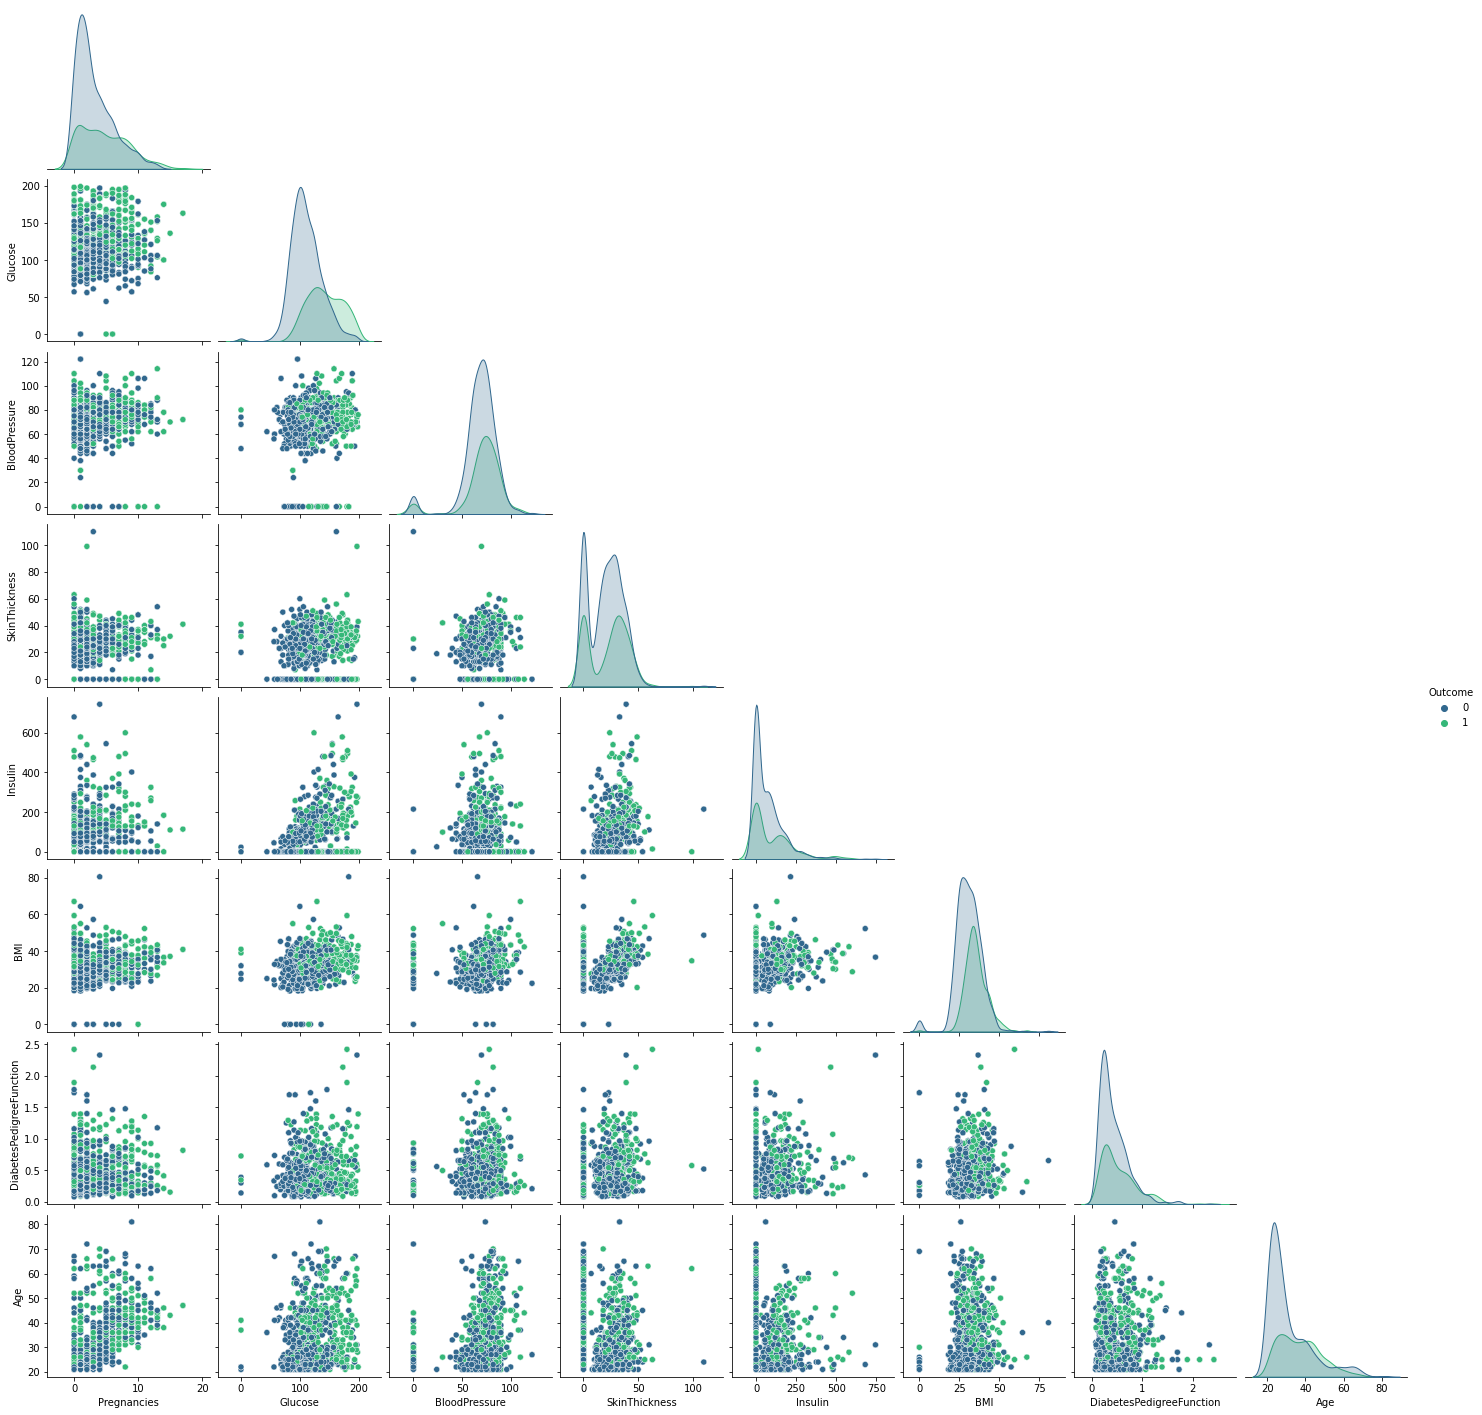

In [5]:
# use pairplot to show relationships between features and individual distributions
sns.pairplot(data=df, hue="Outcome", corner=True, diag_kind="kde", palette="viridis");

## **Data preparation**

In [6]:
#drop duplicate rows
df_prep = df.drop_duplicates()

#copy df
df_prep = df_prep.copy()

#imp
imp = IterativeImputer(missing_values = 0, max_iter=10, random_state=0)
imp.fit(df_prep[['SkinThickness', 'Glucose', 'BloodPressure', 'BMI', 'Insulin']])

#transform
df_ii = imp.transform(df_prep[['SkinThickness', 'Glucose', 'BloodPressure', 'BMI', 'Insulin']])

#replace
df_prep[['SkinThickness', 'Glucose', 'BloodPressure', 'BMI', 'Insulin']] = df_ii
df_silver = df_prep

In [7]:
# creating EDA report and open the html file
%%capture
df_eda_silver = create_report(df_silver)
df_eda_silver.save('diabetes-dataset-silver-eda') # save as html file to better explore data in a browser tab

For dummy variables:

```
cat_vars=['var_1','var_2','var_3',...,'var_n']
for var in cat_vars:
    cat_list = 'var' + '_' + var
    cat_list = pd.get_dummies(data[var], prefix = var)
    data1 = data.join(cat_list)
    data = data1

cat_vars = ['var_1','var_2','var_3',...,'var_n']
data_vars = data.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

data_final = data[to_keep]
data_final.columns.values

Credits: Susan Li | https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
```



## **Modeling - statsmodel (to be update)**

In [8]:
# extract the explanatory variables
y = df_silver.Outcome.copy()
X = df_silver.drop(['Outcome'], axis=1)

In [9]:
# model statistics
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.575902
         Iterations 5
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.102     
Dependent Variable:    Outcome            AIC:                872.9421  
Date:                  2022-03-16 01:22   BIC:                909.8385  
No. Observations:      744                Log-Likelihood:     -428.47   
Df Model:              7                  LL-Null:            -476.96   
Df Residuals:          736                LLR p-value:        4.5480e-18
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        5.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Pregnancies               0.1217   0.0294  4.1365 0

#### **Model test (Chi-square)**
$Chi^2=-2.(LL_0-LL_{max})$ <br>
$p-value = Sig.Chi^2$

#### Stepwise: statiscal test analysis (Z-test)

In [10]:
# remove cols p-value > 0.05
cols = ['Pregnancies'
        ,'Glucose'
        ,'BloodPressure'
        ,'SkinThickness'
        ,'Insulin'
        ] 

X = df_silver[cols]

# extract model statistics
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.578901
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.097     
Dependent Variable: Outcome          AIC:              871.4052  
Date:               2022-03-16 01:22 BIC:              894.4654  
No. Observations:   744              Log-Likelihood:   -430.70   
Df Model:           4                LL-Null:          -476.96   
Df Residuals:       739              LLR p-value:      3.8587e-19
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Pregnancies        0.1196   0.0253  4.7246 0.0000  0.0700  0.1692
Glucose            0.0141   0.0035  4.0758 0.0000  0.0073  0.0209


In [11]:
# remove cols p-value > 0.05
cols = ['Pregnancies'
        ,'Glucose'
        ,'BloodPressure'
        ,'Insulin'
        ] 

X = df_silver[cols]

# extract model statistics
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.580795
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.094     
Dependent Variable: Outcome          AIC:              872.2234  
Date:               2022-03-16 01:22 BIC:              890.6716  
No. Observations:   744              Log-Likelihood:   -432.11   
Df Model:           3                LL-Null:          -476.96   
Df Residuals:       740              LLR p-value:      2.5530e-19
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Pregnancies        0.1196   0.0253  4.7326 0.0000  0.0701  0.1691
Glucose            0.0150   0.0034  4.3716 0.0000  0.0083  0.0217


## **Modeling - scikit learn**

In [132]:
# extract the explanatory variables
y = df_silver.Outcome.copy()
X = df_silver.drop(['Outcome'], axis=1)

# split train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=907)

# training the model
logreg = LogisticRegression(C=0.2, max_iter=1000)
logreg.fit(X_train, y_train)

# predicting
y_pred = logreg.predict(X_test)

# create phat column
y_pred_series = pd.Series(logreg.predict(X_test))

# prep
y_test = y_test.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

df_prob = pd.DataFrame(logreg.predict_proba(X_test))
df_prob = df_prob.rename(columns = {0:'non_prop', 1:'phat'})
df_prob = df_prob['phat']

# concatenate df & series
df_full = pd.concat([X_test, y_test, df_prob, y_pred_series], axis=1)
df_full = df_full.rename(columns = {0:'prediction'})

# compare train & test distribuition
y_train_dist = y_train.sum()/len(y_train)
y_test_dist = y_test.sum()/len(y_test)


# statistics
print('+',30*'-','MODEL STATISTICS',30*'-','+')
print('Train dist: {}%'.format(round(y_train_dist*100, 2))
        ,'| Test dist: {}%'.format(round(y_test_dist*100, 2)))
print(80*'-')
print("Accuracy: {}%".format((metrics.accuracy_score(y_test, y_pred)*100).round(2))
        ,"| Precision: {}%".format((metrics.precision_score(y_test, y_pred)*100).round(2))
        ,"| Recall: {}%".format((metrics.recall_score(y_test, y_pred)*100).round(2)))
print(80*'-')
print("AUC: {}%".format((roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])*100).round(2))
        ,"| F1: {}%".format(((f1_score(y_test, y_pred))*100).round(2))
        ,'| LL: {}'.format(-metrics.log_loss(y_test, logreg.predict_proba(X_test), normalize=False)))
print(80*'-')
print('Intercept: {}'.format(logreg.intercept_))
print(80*'-')
print('Coeficientes:{}'.format(logreg.coef_))
print('+',78*'-','+')

# take a look to df
df_full.sort_values('phat')

+ ------------------------------ MODEL STATISTICS ------------------------------ +
Train dist: 33.33% | Test dist: 34.68%
--------------------------------------------------------------------------------
Accuracy: 76.34% | Precision: 72.53% | Recall: 51.16%
--------------------------------------------------------------------------------
AUC: 84.15% | F1: 60.0% | LL: -180.1615156519352
--------------------------------------------------------------------------------
Intercept: [-8.47689847]
--------------------------------------------------------------------------------
Coeficientes:[[ 7.63711407e-02  3.81233639e-02 -1.37217702e-03 -8.89580878e-03
  -2.04977273e-04  7.90414112e-02  4.28632434e-01  6.34347262e-03]]
+ ------------------------------------------------------------------------------ +


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,phat,prediction
258,0,57.0,60.0000,16.811832,10.355318,21.7,0.735,67,0,0.016584,0
110,1,71.0,48.0000,18.000000,76.000000,20.4,0.323,22,0,0.017210,0
64,0,73.0,64.9839,16.887209,40.530642,21.1,0.342,25,0,0.018549,0
346,1,71.0,62.0000,17.345794,37.817306,21.8,0.416,26,0,0.020341,0
224,1,73.0,50.0000,10.000000,42.818245,23.0,0.248,21,0,0.023513,0
...,...,...,...,...,...,...,...,...,...,...,...
327,9,171.0,110.0000,24.000000,240.000000,45.4,0.721,54,1,0.927974,1
151,4,197.0,70.0000,39.000000,744.000000,36.7,2.329,31,0,0.944755,1
369,5,187.0,76.0000,27.000000,207.000000,43.6,1.034,53,1,0.946482,1
324,0,180.0,78.0000,63.000000,14.000000,59.4,2.420,25,1,0.973556,1


## **Validation**

### **Confusion Matrix**

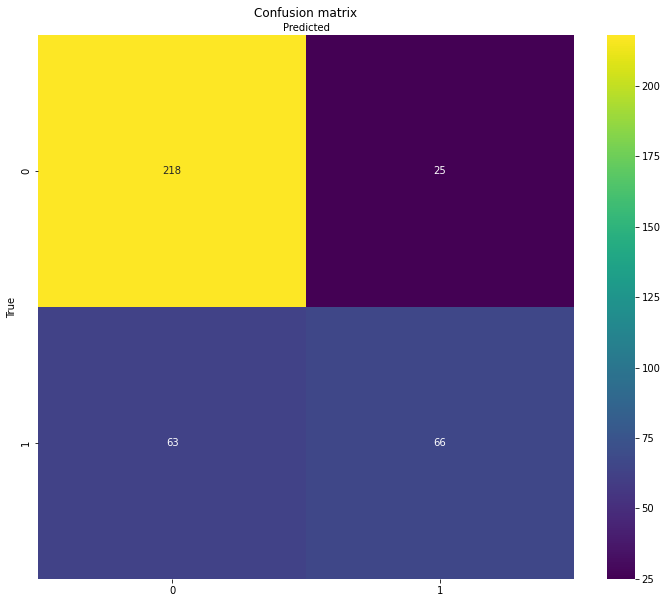

In [9]:
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

labels = [0, 1]
fig, ax = plt.subplots(figsize=(12, 10))
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted');

### **Precision-Recall Curves**

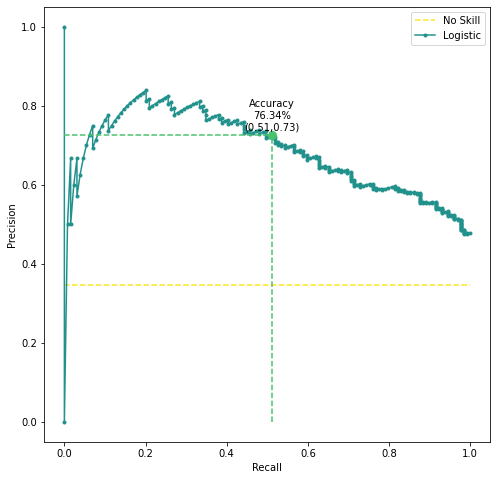

In [13]:
### Predict test_y values and probabilities based on fitted logistic regression model
yhat = logreg.predict_proba(X_test) 

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# predict class values
lr_precision, lr_recall, _ = precision_recall_curve(y_test, yhat)

# plot the precision-recall curves
plt.figure(figsize=(8, 8))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color='#fde725')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic', color='#21918c')

# plot the accuracy point
accuracy = ((metrics.accuracy_score(y_test, y_pred)*100).round(2))
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

plt.plot([recall, recall], [0,precision], linestyle='--',  color='#4ac16d')
plt.plot([0, recall], [precision, precision], linestyle='--',  color='#4ac16d')
plt.text(recall,precision+0.05,'Accuracy\n{}%\n({},{})'
                                                        .format(accuracy
                                                                ,((recall).round(2))
                                                                ,((precision).round(2))
                                                                )
                                                        , horizontalalignment='center', verticalalignment='center')
plt.plot(recall,precision, 'r+', marker='o', color='#4ac16d',markersize=8)


# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the legend
plt.legend()

# show the plot
plt.show()

### **Precision-Recall vs Threshold**

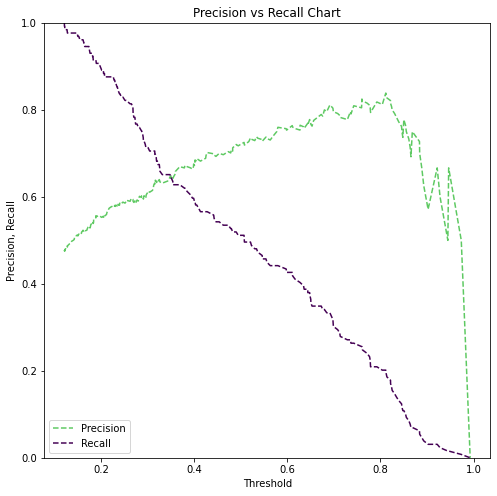

In [14]:
### Predict test_y values and probabilities based on fitted logistic regression model
yhat = logreg.predict_proba(X_test) 

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# yhat is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)
precision, recall, thresholds = precision_recall_curve(y_test, yhat) 

#retrieve probability of being 1(in second column of yhat)
plt.figure(figsize=(8, 8))
plt.title("Precision vs Recall Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision", color='#5ec962')
plt.plot(thresholds, recall[: -1], "r--", label="Recall", color='#440154')
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1]);

### **ROC Curve: ROC AUC & Gini's coefficient**

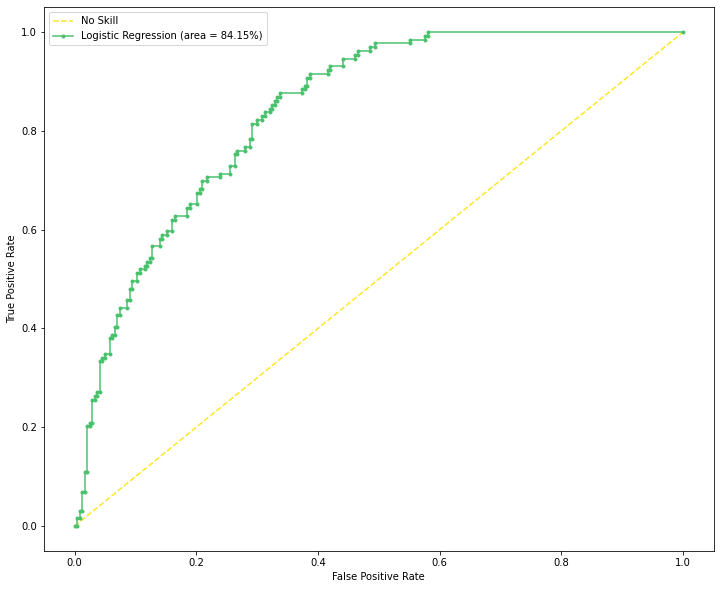

In [15]:
from numpy import sqrt
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# plot the roc curve for the model
plt.figure(figsize=(12, 10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725')
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', label='Logistic Regression (area = {}%)'.format((roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])*100).round(2)))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# show the plot
plt.show()

---

## **Tunning the model: optimal thresholds**

(ref: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)
1. G-Mean (Gaussian Mean)
2. Precision-Recall Curve
3. Auto threshhold (empirical)
4. Cost function (weighted function)
5. Specific Precision Recall

### **1. G-Mean or Youden’s J statistic**
Threshold with the optimal balance between false positive and true positive rates.

<br>$G-Mean = \sqrt{Sensitivity . Specificity} \quad \textrm{or} \quad 
J = Sensitivity + Specifity - 1$ <br>
$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad = TruePositiveRate - FalsePositiveRate$

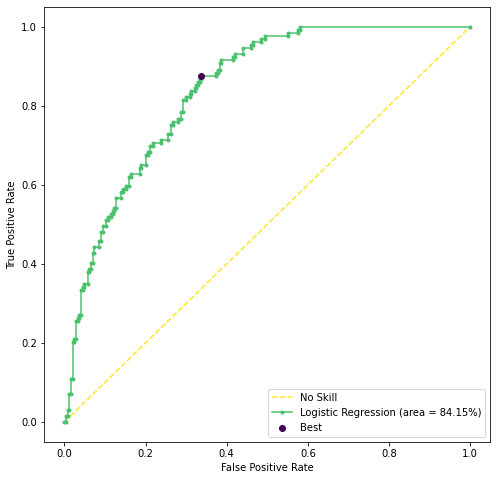

Best Threshold=0.226204, G-Mean=0.762


In [18]:
from numpy import sqrt
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)


'''
# get the best threshold (Youden’s J statistic)
J = tpr - fpr
ix = argmax(J)
'''

# plot the roc curve for the model
plt.figure(figsize=(8, 8))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725', zorder=1)
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', zorder=2, label='Logistic Regression (area = {}%)'.format((roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])*100).round(2)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='#440154', label='Best', zorder=3)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# show the plot
plt.show()
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

### **2. Precision-Recall Curve**
Threshold that results in the best balance of precision and recall

<br>$fscore = \frac{(2*Precision*Recall)}{(Precision + Recall)}$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


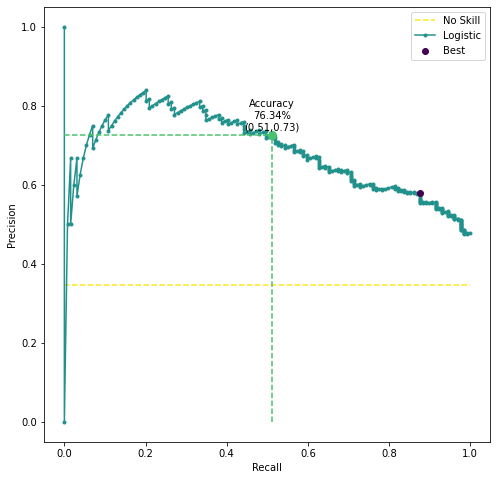

Best Threshold=0.226204, F-Score=0.698


In [100]:
from numpy import argmax
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot


# locate the index of the largest f score
ix = argmax(fscore)

### Predict test_y values and probabilities based on fitted logistic regression model
yhat = logreg.predict_proba(X_test) 

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate precision-recall curves
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

# convert to f score
fscore = ((2 * precision * recall) / (precision + recall))
fscore = fscore[~np.isnan(fscore)]

# locate the index of the largest f score
ix = argmax(fscore)

# plot the roc curve for the model
plt.figure(figsize=(8, 8))
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', zorder=1, label='No Skill', color='#fde725')
pyplot.plot(recall, precision, marker='.', zorder=2, label='Logistic', color='#21918c')
pyplot.scatter(recall[ix], precision[ix], marker='o', zorder=3, color='#440154', label='Best')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()



# plot the accuracy point
accuracy = ((metrics.accuracy_score(y_test, y_pred)*100).round(2))
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

plt.plot([recall, recall], [0,precision], linestyle='--',  color='#4ac16d')
plt.plot([0, recall], [precision, precision], linestyle='--',  color='#4ac16d')
plt.text(recall,precision+0.05,'Accuracy\n{}%\n({},{})'
                                                        .format(accuracy
                                                                ,((recall).round(2))
                                                                ,((precision).round(2))
                                                                )
                                                        , horizontalalignment='center', verticalalignment='center')
plt.plot(recall,precision, 'r+', marker='o', color='#4ac16d',markersize=8)


# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the legend
plt.legend()

# show the plot
pyplot.show();
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

### **3. Auto threshhold (empirical)**
We can define a set of thresholds and then evaluate predicted probabilities under each in order to find and select the optimal threshold.

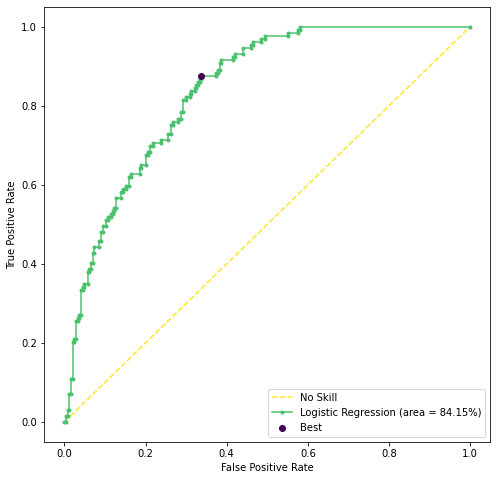

Threshold=0.226, F-Score=0.62621


In [102]:
from numpy import arange
from numpy import argmax
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

### Predict test_y values and probabilities based on fitted logistic regression model
yhat = logreg.predict_proba(X_test) 

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# define thresholds
thresholds = arange(0, 1, 0.001)

# evaluate each threshold
scores = [f1_score(y_test, to_labels(yhat, t)) for t in thresholds]

# get best threshold
ix = argmax(scores)

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)

# plot the roc curve for the model
plt.figure(figsize=(8, 8))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725', zorder=1)
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', zorder=2, label='Logistic Regression (area = {}%)'.format((roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])*100).round(2)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='#440154', label='Best', zorder=3)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# show the plot
plt.show()
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

### **4. Cost function (weighted function)**

In [284]:
# create a cost function
def cost_function(tn, fp, fn, tp):
    cost = 0
    
    cost += (tn * 100) 
    cost += (fp * -10) 
    cost += (fn * -100) 
    cost += (tp * 10) 
    
    return cost

### Predict test_y values and probabilities based on fitted logistic regression model
yhat = logreg.predict_proba(X_test) 

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate precision-recall curves
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

costs = []
tns = []
fps = []
fns = []
tps = []

for threshold in thresholds:
    y_pred_with_threshold = (yhat >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_with_threshold).ravel()
    costs.append(cost_function(tn, fp, fn, tp))
    tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)

df_cost = pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'threshold':thresholds, 'cost':costs, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})
        
min_cost = df_cost['cost'].min()
threshold = df_cost[df_cost['cost']==min_cost].iloc[0]['threshold']
ix = np.argmax(thresholds >= threshold)
threshold, min_cost, df_cost.sort_values('cost')

(0.12134431393260854,
 9970,
      precision    recall  threshold   cost   tn   fp  fn   tp
 1     0.475836  0.992248   0.121344   9970  102  141   1  128
 3     0.475655  0.984496   0.122255   9970  103  140   2  127
 0     0.477778  1.000000   0.121197  10080  102  141   0  129
 2     0.477612  0.992248   0.121985  10080  103  140   1  128
 4     0.477444  0.984496   0.122965  10080  104  139   2  127
 ..         ...       ...        ...    ...  ...  ...  ..  ...
 167   0.699029  0.558140   0.441846  15910  212   31  57   72
 177   0.720430  0.519380   0.490202  15910  217   26  62   67
 151   0.672269  0.620155   0.380053  15910  204   39  49   80
 149   0.669421  0.627907   0.369064  15910  203   40  48   81
 166   0.701923  0.565891   0.427867  16020  212   31  56   73
 
 [270 rows x 8 columns])

### **5. Specific Precision/Recall**

In [321]:
# Predict test_y values and probabilities and keep probabilities for the positive outcome only
yhat = logreg.predict_proba(X_test)[:, 1]
ix = 0

def threshold_from_desired_precision(y_test, desired_precision):
    global ix
    precisions, recall, thresholds = precision_recall_curve(y_test, yhat)
    desired_precision_ix = np.argmax(precision >= desired_precision)
    ix = desired_precision_ix
    return thresholds[ix], precision[ix], recall[ix], ix

print('desired_precision (0.6): ', threshold_from_desired_precision(y_test, 0.6))

desired_precision (0.6):  (0.28241677645303653, 0.6012269938650306, 0.7596899224806202, 107)


In [319]:
# Predict test_y values and probabilities and keep probabilities for the positive outcome only
yhat = logreg.predict_proba(X_test)[:, 1]
ix = 0

def threshold_from_desired_recall(y_test, desired_recall):
    global ix
    precision, recall, thresholds = precision_recall_curve(y_test, yhat)
    desired_recall_ix = np.argmin(recall >= desired_recall)
    ix = desired_recall_ix
    return thresholds[ix], precision[ix], recall[ix], ix

print('desired_recall (0.6): ', threshold_from_desired_recall(y_test, 0.6))

desired_recall (0.6):  (0.39641764455030426, 0.6637931034482759, 0.5968992248062015, 154)


### **New tunned model outcomes**

In [327]:
# concatenate df & series
df_full2 = pd.concat([X_test, y_test, df_prob], axis=1)
df_full2['yhat'] = ''

df_full2['yhat'] = np.where(df_full2['phat']> thresholds[ix], 1, 0)

df_full2.sort_values('yhat')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,phat,yhat
371,8,120.0,86.000000,25.781152,140.249602,28.4,0.259,22,1,0.236516,0
159,2,87.0,58.000000,16.000000,52.000000,32.7,0.166,25,0,0.081241,0
305,10,68.0,106.000000,23.000000,49.000000,35.5,0.285,47,0,0.094951,0
161,2,88.0,58.000000,26.000000,16.000000,28.4,0.766,22,0,0.071042,0
162,2,93.0,64.000000,32.000000,160.000000,38.0,0.674,23,1,0.148604,0
...,...,...,...,...,...,...,...,...,...,...,...
370,13,158.0,114.000000,40.875692,230.084969,42.3,0.257,44,1,0.846177,1
186,1,139.0,62.000000,41.000000,480.000000,40.7,0.536,21,0,0.482600,1
190,0,128.0,68.000000,19.000000,180.000000,30.5,1.391,25,1,0.325029,1
165,2,129.0,74.775409,34.819146,172.230518,38.5,0.304,41,0,0.396418,1


In [328]:
# statistics
print('+',30*'-','MODEL STATISTICS',30*'-','+')
print('Train dist: {}%'.format(round(y_train_dist*100, 2))
        ,'| Test dist: {}%'.format(round(y_test_dist*100, 2)))
print(80*'-')
print("Accuracy: {}%".format((metrics.accuracy_score(df_full2['Outcome'], df_full2['yhat'])*100).round(2))
        ,"| Precision: {}%".format((metrics.precision_score(df_full2['Outcome'], df_full2['yhat'])*100).round(2))
        ,"| Recall: {}%".format((metrics.recall_score(df_full2['Outcome'], df_full2['yhat'])*100).round(2)))
print(80*'-')
print("AUC: {}%".format((roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])*100).round(2))
        ,"| F1: {}%".format(((f1_score(df_full2['Outcome'], df_full2['yhat']))*100).round(2))
        ,'| LL: {}'.format(-metrics.log_loss(y_test, logreg.predict_proba(X_test), normalize=False)))
print(80*'-')
print('Intercept: {}'.format(logreg.intercept_))
print(80*'-')
print('Coeficientes:{}'.format(logreg.coef_))
print('+',78*'-','+')

# take a look to df
df_full2.sort_values('phat')

+ ------------------------------ MODEL STATISTICS ------------------------------ +
Train dist: 33.33% | Test dist: 34.68%
--------------------------------------------------------------------------------
Accuracy: 73.92% | Precision: 59.88% | Recall: 75.19%
--------------------------------------------------------------------------------
AUC: 84.15% | F1: 66.67% | LL: -180.1615156519352
--------------------------------------------------------------------------------
Intercept: [-8.47689847]
--------------------------------------------------------------------------------
Coeficientes:[[ 7.63711407e-02  3.81233639e-02 -1.37217702e-03 -8.89580878e-03
  -2.04977273e-04  7.90414112e-02  4.28632434e-01  6.34347262e-03]]
+ ------------------------------------------------------------------------------ +


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,phat,yhat
258,0,57.0,60.0000,16.811832,10.355318,21.7,0.735,67,0,0.016584,0
110,1,71.0,48.0000,18.000000,76.000000,20.4,0.323,22,0,0.017210,0
64,0,73.0,64.9839,16.887209,40.530642,21.1,0.342,25,0,0.018549,0
346,1,71.0,62.0000,17.345794,37.817306,21.8,0.416,26,0,0.020341,0
224,1,73.0,50.0000,10.000000,42.818245,23.0,0.248,21,0,0.023513,0
...,...,...,...,...,...,...,...,...,...,...,...
327,9,171.0,110.0000,24.000000,240.000000,45.4,0.721,54,1,0.927974,1
151,4,197.0,70.0000,39.000000,744.000000,36.7,2.329,31,0,0.944755,1
369,5,187.0,76.0000,27.000000,207.000000,43.6,1.034,53,1,0.946482,1
324,0,180.0,78.0000,63.000000,14.000000,59.4,2.420,25,1,0.973556,1


---

# **That's all folks!**

In [331]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_tpr_minus_fpr(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_scores) 

        optimal_idx = np.argmax(tpr - fpr)

        return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]


    def threshold_from_optimal_f_score(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        fscores = (2 * precisions * recalls) / (precisions + recalls)
        
        optimal_idx = np.argmax(fscores)
        
        return thresholds[optimal_idx], fscores[optimal_idx]
    
    def threshold_from_desired_precision(self, X, y, desired_precision=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_precision_idx = np.argmax(precisions >= desired_precision)
        
        return thresholds[desired_precision_idx], recalls[desired_precision_idx]

    def threshold_from_desired_recall(self, X, y, desired_recall=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_recall_idx = np.argmin(recalls >= desired_recall)
        
        return thresholds[desired_recall_idx], precisions[desired_recall_idx]
    
    def threshold_from_optimal_accuracy(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
        
        accuracies = []
        tns = []
        fps = []
        fns = []
        tps = []

        for threshold in thresholds:
            y_pred_with_threshold = (y_scores >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y, y_pred_with_threshold).ravel()

            accuracies.append((tp+tn)/(tn+fp+fn+tp))
            tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)
        
        df_accuracy = pd.DataFrame({'threshold':thresholds, 'accuracy':accuracies, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})

        max_accuracy = df_accuracy['accuracy'].max()
        threshold = df_accuracy[df_accuracy['accuracy']==max_accuracy].iloc[0]['threshold']

        return threshold, max_accuracy, df_accuracy

lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

threshold, max_accuracy, df_accuracy = lrt.threshold_from_optimal_accuracy(X_train, y_train)
y_pred = lrt.predict(X_train, threshold)

threshold, max_accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(0.43292565347165063, 0.771505376344086)